# What is Parquet

## Definition

> **Apache Parquet** is an open source, column-oriented data file format designed for efficient data storage and retrieval. It provides high performance compression and encoding schemes to handle complex data in bulk and is supported in many programming language and analytics tools.

It is a top level Apache project donated by Twitter and Cloudera. It is an efficient columnar storage format.

Parquet is built to support very efficient compression and encoding schemes.

Parquet is a columnar file format that excels at being read for analytical queries.

> Parquet is built from the ground up with complex nested data structures in mind, and uses the record shredding and assembly algorithm described in the Dremel paper.


## Why should you care

- Efficient for handling data at scale
- Widely adopted in the big data ecosystem
- Multiple languages and frameworks supported

## What Exactly is meant by `Columnar`

### Row Based

Think `.csv`

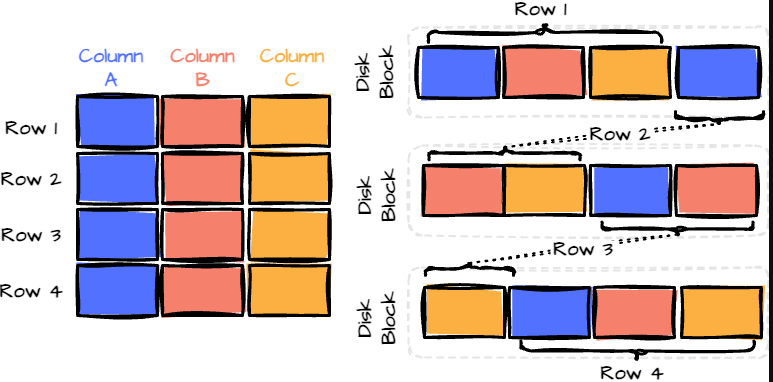

### Column Based

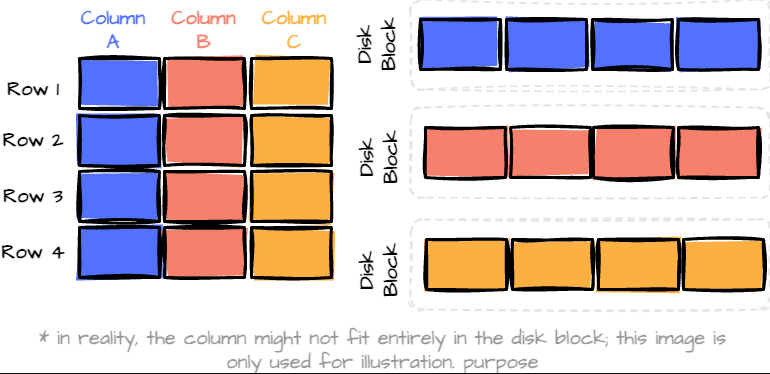

### Thought example

We have a data set with 100 columns x 1_000_000 rows and we want to sum up a price column. For row based we have to read through the entire file to get all of the price columns. In column based we can skip to that columns location in memory and only read those disc blocks that have the price column's data.

## Code Example

In [1]:
# Imports for use later
import polars as pl
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

## Lets use some parquet

Data set from [Kaggle](https://www.kaggle.com/datasets/mexwell/pizza-sales)

In [2]:
df = pl.read_csv('pizza_sales.csv')
df.shape

(49574, 9)

In [3]:
df.head()

,X,id,date,time,name,size,type,price
i64,i64,str,str,str,str,str,str,f64
1,1,"""2015-000001""","""2015-01-01""","""11:38:36""","""hawaiian""","""M""","""classic""",13.25
2,2,"""2015-000002""","""2015-01-01""","""11:57:40""","""classic_dlx""","""M""","""classic""",16.0
3,3,"""2015-000002""","""2015-01-01""","""11:57:40""","""mexicana""","""M""","""veggie""",16.0
4,4,"""2015-000002""","""2015-01-01""","""11:57:40""","""thai_ckn""","""L""","""chicken""",20.75
5,5,"""2015-000002""","""2015-01-01""","""11:57:40""","""five_cheese""","""L""","""veggie""",18.5


### Write out as Parquet

In [4]:
df.write_parquet('pizza_sales.parquet')

### Read in the Parquet

In [37]:
df = pl.read_parquet('pizza_sales.parquet')  # scan_parquet for lazy
df.shape

(49574, 9)

### Example Query

In [42]:
df.filter(pl.col('size') == "L") \
  .group_by('name') \
  .agg(pl.max('price'))\
  .sort('name')

name,price
str,f64
"""bbq_ckn""",20.75
"""calabrese""",20.25
"""cali_ckn""",20.75
"""ckn_alfredo""",20.75
"""ckn_pesto""",20.75
…,…
"""spinach_fet""",20.25
"""spinach_supr""",20.75
"""thai_ckn""",20.75


## Key Features

1. Column storage
2. Schema awareness and metadata
3. Compression (gzip, snappy, etc)
4. Encoding (RLE, bit packing, etc)

## How it works

Row groups - data is divided into row groups for efficient storage and retreival

Pages - each column in a row group is split into pages and compressed independently

Meta data - stores metadata about the file structure, schema and compression details

### Row Groups

**Note** Above columnar image is wrong. Parquet is more like a `hybrid`

The data is structured in `chunks` called row groups and is not as congruent as the above picture led you to believe.

Row groups are a subset of the data


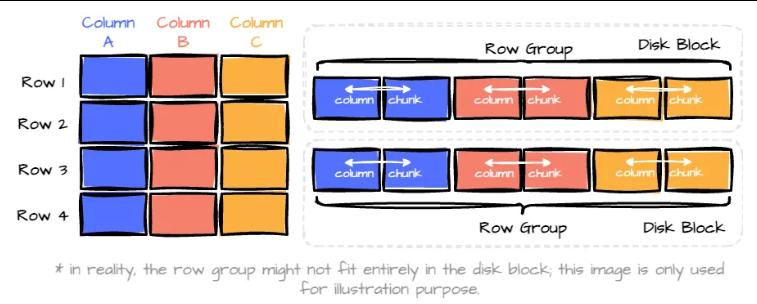

### Column Chunk

Chunk is the data for a particular column in the row group

### Page

Column chunks are further broken down into pages. 

Pages are the smallest subdivision in parquet and come in 3 different types.

1. Data (Actual column data)
2. Dictionary (for encoding values)
3. Index (Metadata, offsets, etc...)

## Metadata

The `secret sauce` of parquet!

The file contains copious amounts of meta data from the file itself, down to the page level for what is contained within the file itself. Metadata is actually stored in the footer of the document.

Metadata conains:

- schema
- counts
- size both compressed and uncompressed
- min/max
- disk offsets

[Metadata docs](https://parquet.apache.org/docs/file-format/metadata/)

## Query Example

```sql
SELECT column_a, SUM(column_b)
FROM my_table
WHERE column_c < 10
GROUP BY column_a;
```

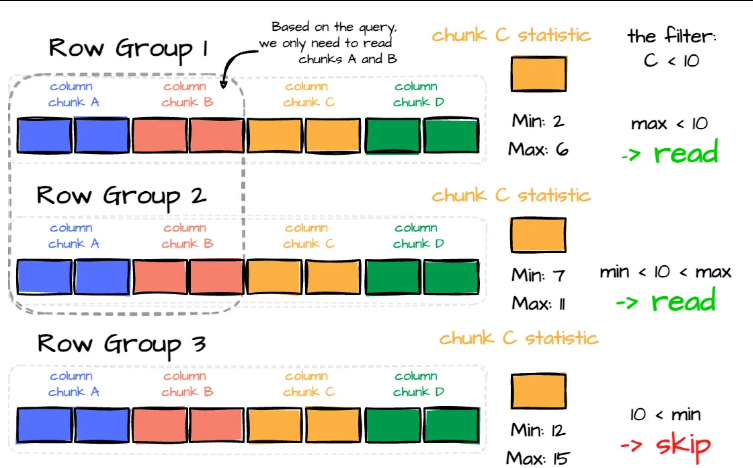

With the above data the 2 row groups of data are needed so only a couple portions of the file need to be read/scan!

Row group 3's minimum value for column C is outside the filter.

## Lets take a look

Lets create a small file to better see the inner workings

In [94]:
# Sample data. Note the None
data = {
    "id": ["A1", None, "A3"],
    "tens": [10, 50, 30],
    "ones": [1.1, 2.2, 3.3],
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Convert the pandas DataFrame to a pyarrow Table
table = pa.Table.from_pandas(df)

# Write the table to Parquet without compression
pq.write_table(table,  'tiny.parquet', compression='NONE')


### Visualize the binary parquet file

If you try to open the file in VsCode you will get an error. That's becvause parquet is a binary file and not a "text" file like csv.

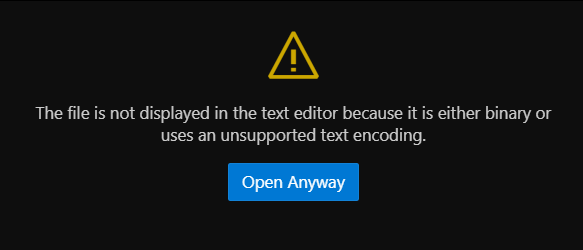

You could try to use a hex editor if you felt bold...

Some things will be legible but not useful. 

Magic number at the beginning and end tells applications that it is a valid parquet file.

In [54]:
!Powershell "Format-Hex .\tiny.parquet"



           Path: G:\code\machine-learning\parquet_example\tiny.parquet

           00 01 02 03 04 05 06 07 08 09 0A 0B 0C 0D 0E 0F

00000000   50 41 52 31 15 04 15 24 15 24 4C 15 06 15 00 12  PAR1...$.$L.....
00000010   00 00 02 00 00 00 41 31 02 00 00 00 41 32 02 00  ......A1....A2..
00000020   00 00 41 33 15 00 15 14 15 14 2C 15 06 15 10 15  ..A3......,.....
00000030   06 15 06 1C 36 00 28 02 41 33 18 02 41 31 00 00  ....6.(.A3..A1..
00000040   00 02 00 00 00 06 01 02 03 24 00 26 96 01 1C 15  .........$.&?...
00000050   0C 19 35 00 06 10 19 18 02 69 64 15 00 16 06 16  ..5......id.....
00000060   8E 01 16 8E 01 26 48 26 08 1C 36 00 28 02 41 33  ?..?.&H&..6.(.A3
00000070   18 02 41 31 00 19 2C 15 04 15 00 15 02 00 15 00  ..A1..,.........
00000080   15 10 15 02 00 00 00 15 04 15 30 15 30 4C 15 06  ..........0.0L..
00000090   15 00 12 00 00 0A 00 00 00 00 00 00 00 14 00 00  ................
000000A0   00 00 00 00 00 1E 00 00 00 00 00 00 00 15 00 15  ................
000000B0   14 15 14

Set-PSReadLineOption : The predictive suggestion feature cannot be enabled because the console output doesn't support virtual terminal processing or it's 
redirected.
At C:\Users\gamer\Documents\WindowsPowerShell\Microsoft.PowerShell_profile.ps1:3 char:1
+ Set-PSReadLineOption -PredictionSource History
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : NotSpecified: (:) [Set-PSReadLineOption], ArgumentException
    + FullyQualifiedErrorId : System.ArgumentException,Microsoft.PowerShell.SetPSReadLineOption
 
Set-PSReadLineOption : The handle is invalid.
At C:\Users\gamer\Documents\WindowsPowerShell\Microsoft.PowerShell_profile.ps1:4 char:1
+ Set-PSReadLineOption -PredictionViewStyle ListView
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : NotSpecified: (:) [Set-PSReadLineOption], IOException
    + FullyQualifiedErrorId : System.IO.IOException,Microsoft.PowerShell.SetPSReadLineOption
 


Depending on "who" wrote out the file different parts are more recognizable. Here in this pandas example you can see a json blob about columns.

```json
..pandas..
{
    "index_columns": [
        {
            "kind": "range",
            "name": null,
            "start": 0,
            "stop": 3,
            "step": 1
        }
    ],
    "column_indexes": [
        {
            "name": null,
            "field_name": null,
            "pandas_type": "unicode",
            "numpy_type": "object",
            "metadata": {
                "encoding": "UTF-8"
            }
        }
    ],
    "columns": [
        {
            "name": "id",
            "field_name": "id",
            "pandas_type": "unicode",
            "numpy_type": "object",
            "metadata": null
        },
        {
            "name": "tens",
            "field_name": "tens",
            "pandas_type": "int64",
            "numpy_type": "int64",
            "metadata": null
        },
        {
            "name": "ones",
            "field_name": "ones",
            "pandas_type": "float64",
            "numpy_type": "float64",
            "metadata": null
        }
    ],
    "creator": {
        "library": "pyarrow",
        "version": "17.0.0"
    },
    "pandas_version": "1.4.2"
}
```

In [92]:
# Open the Parquet file
parquet_file = pq.ParquetFile('tiny.parquet')

# Get file metadata
metadata = parquet_file.metadata

# Print metadata information
print("Parquet Metadata:")
print(metadata)

Parquet Metadata:
  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 3
  num_rows: 3
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 2284


In [93]:
# Print row groups
for i in range(metadata.num_row_groups):
    row_group = metadata.row_group(i)
    print(f"Row Group {i}:")
    print(f"  Number of rows: {row_group.num_rows}")
    print(f"  Total byte size: {row_group.total_byte_size}")
    
    # Print column metadata within each row group
    for j in range(row_group.num_columns):
        column = row_group.column(j)
        print(f"\n  Column {j}:")
#         print(f"    Name: {column.name}")
#         print(dir(column))
        print(f"    Type: {column.physical_type}")
        print(f"    Number of values: {column.num_values}")
#         print(f"    Total byte size com: {column.total_compressed_size}")
#         print(f"    Total byte size: un: {column.total_uncompressed_size}")
#         print(f"    Compression: {column.compression}")
        print(f"    Schema path: {column.path_in_schema}")
        print(f"    statistics: {column.statistics}")
        print()

Row Group 0:
  Number of rows: 3
  Total byte size: 282

  Column 0:
    Type: BYTE_ARRAY
    Number of values: 3
    Schema path: id
    statistics: <pyarrow._parquet.Statistics object at 0x000001A04BA029A0>
  has_min_max: True
  min: A1
  max: A3
  null_count: 1
  distinct_count: None
  num_values: 2
  physical_type: BYTE_ARRAY
  logical_type: String
  converted_type (legacy): UTF8


  Column 1:
    Type: INT64
    Number of values: 3
    Schema path: tens
    statistics: <pyarrow._parquet.Statistics object at 0x000001A04BA029F0>
  has_min_max: True
  min: 10
  max: 50
  null_count: 0
  distinct_count: None
  num_values: 3
  physical_type: INT64
  logical_type: None
  converted_type (legacy): NONE


  Column 2:
    Type: DOUBLE
    Number of values: 3
    Schema path: ones
    statistics: <pyarrow._parquet.Statistics object at 0x000001A04BA02AE0>
  has_min_max: True
  min: 1.1
  max: 3.3
  null_count: 0
  distinct_count: None
  num_values: 3
  physical_type: DOUBLE
  logical_type: No

## Best Practices

- Use appropriate datatypes. E.g. ints instead of strings for better compression (bit packing)
- Partition files for better query performance